In [1]:
import numpy as np
import pandas as pd

## Load external data

In [2]:
freq = 'w'

#### Prices

In [3]:
filepath = '../../data/external/'
filename = 'price_db_' + freq + '.pkl'
price_db = pd.read_pickle(filepath+filename)

Make `df_rt`, a matrix of log returns of all eligible **instruments** in the universe with:
- Columns: itemcode
- Rows: date

In [4]:
df_rt = price_db[price_db.itemtype=='ETF'].pivot(index='date', columns='itemcode', values='ret').dropna()

## Estimaing mean risk portfolios

- Using ***CDaR*** instead of variance as a risk measure.
  - Conditional Drawdown at Risk(CDaR) is the average drawdown for all the instances that drawdown **exceeded** a certain threshold. Drawdown is a measure of downside risk.
  - https://breakingdownfinance.com/finance-topics/alternative-investments/conditional-drawdown-at-risk-cdar/

In [32]:
import riskfolio.Portfolio as pf
import datetime

`y` is a matrix of log returns of all eligible instruments in the universe.

In [47]:
current_date = '2020-01-10'
y = df_rt[df_rt.index <= current_date]

In [48]:
df_rf = price_db[price_db.itemtype=='riskfree'].set_index('date', drop=True)
current_idx = df_rf.index.asof(datetime.datetime.strptime('2021-03-05', '%Y-%m-%d'))
rf = df_rf.loc[current_idx].price  # risk free rate

In [49]:
port = pf.Portfolio(returns=y) 

In [56]:
method_mu='ewma1'  # Method to estimate expected returns; ewma with adjust=True. See pandas.DataFrame.ewm for more details.
method_cov='ewma1' # Method to estimate covariance matrix; ewma with adjust=True
decay=0.94

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=decay)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CDaR' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
l=0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

You must convert self.cov to a positive definite matrix


In [57]:
instruments=pd.read_pickle('../../data/processed/instruments_m.pkl')

In [52]:
w = pd.merge(w, instruments.loc[:,['itemcode', 'tracking_code']], left_index=True, right_on='itemcode', how='left')

TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

In [53]:
w = w[['weights', 'tracking_code']].set_index('tracking_code')

TypeError: 'NoneType' object is not subscriptable

In [54]:
import riskfolio.PlotFunctions as plf


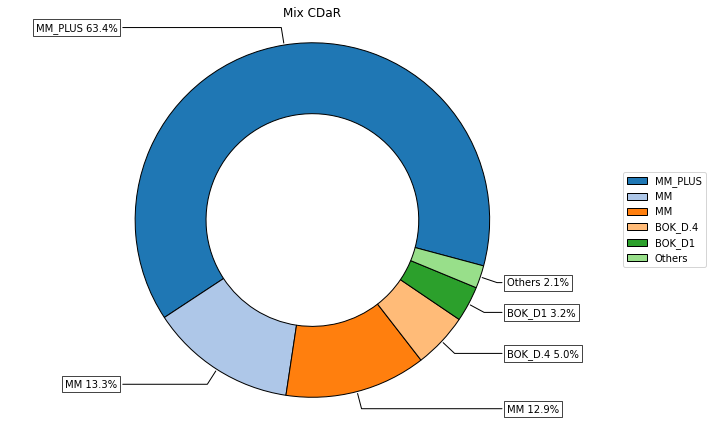

In [42]:
ax = plf.plot_pie(w=w, title='Mix CDaR', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [43]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,A069500,A091160,A091170,A091180,A102110,A102780,A105190,A114260,A122260,A130680,...,A232080,A245340,A245710,A251350,A261220,A261240,A266370,A273130,A278540,A283580
0,1.432168e-04,1.980377e-03,4.083007e-04,8.379170e-05,1.416037e-04,1.130080e-04,1.385363e-04,3.713880e-03,3.241485e-02,1.608042e-04,...,8.762125e-05,0.000264,7.654100e-05,2.417847e-04,1.642126e-04,0.004324,1.127855e-04,2.301831e-03,1.229924e-04,1.311372e-03
1,2.051975e-12,2.844454e-02,4.468999e-13,2.393778e-13,2.066205e-12,6.128341e-02,1.933764e-12,3.403173e-01,9.471059e-11,2.240562e-13,...,3.993616e-13,0.050846,3.715631e-13,5.250008e-12,2.334036e-13,0.170097,4.956875e-12,1.917556e-01,2.455066e-12,5.803103e-13
2,1.145116e-12,1.140747e-11,2.570314e-13,1.844112e-13,1.164513e-12,9.023205e-02,1.121183e-12,1.089441e-11,6.232395e-12,2.856640e-13,...,2.219006e-13,0.098820,2.771813e-13,3.858999e-12,2.941995e-13,0.421188,4.752158e-02,4.645738e-11,1.715152e-12,3.809289e-13
3,8.330681e-14,1.206478e-13,2.107916e-14,1.796386e-14,8.514100e-14,1.157371e-12,8.295727e-14,5.879125e-13,3.762284e-13,2.575913e-14,...,1.819527e-14,0.137404,2.133816e-14,2.885116e-13,2.643679e-14,0.259390,1.395806e-01,1.647192e-12,1.091964e-13,2.946005e-14
4,8.923227e-14,9.171158e-14,3.024796e-14,1.968180e-14,9.099264e-14,6.112274e-13,8.991503e-14,6.117144e-13,4.217075e-13,2.959192e-14,...,2.756237e-14,0.165504,2.736894e-14,3.058467e-13,2.985870e-14,0.138577,1.775384e-01,1.458416e-12,1.058780e-13,3.775764e-14


C:\ProgramData\Anaconda3\envs\ra\lib\site-packages\riskfolio\PlotFunctions.py:337: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (ret - rf) / risk
C:\ProgramData\Anaconda3\envs\ra\lib\site-packages\riskfolio\PlotFunctions.py:359: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (ret - rf) / risk


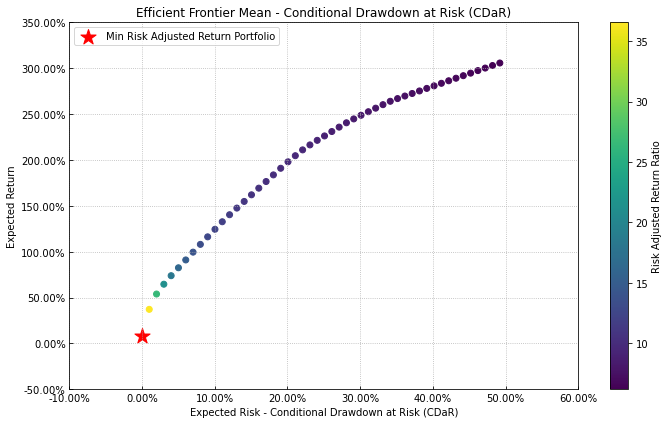

In [44]:
# Plotting the efficient frontier

label = 'Min Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

In [58]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [59]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
A069500,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091160,79.12%,100.00%,100.00%,100.00%,100.00%,100.00%,81.46%,75.12%,31.03%,30.36%,31.03%,38.36%,31.03%
A091170,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A091180,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102110,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A102780,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A105190,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A114260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A122260,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
A130680,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
